In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import os
import matplotlib.pylab as plt
import scipy

# loading time series data

url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv',error_bad_lines=False)  #( time_series_19-covid-Confirmed.csv)
df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)

#df = pd.read_csv(url, error_bad_lines=False)
date='4/14/20'
odir='seiirr_UK_' + date.replace('/','_') + '/'
try:  
    os.mkdir(odir)  
except OSError as error:  
    print('Directory exists: ', odir)

df_confirmed=df_confirmed.groupby(['Country']).sum()
df_confirmed=df_confirmed.drop(columns=['Lat','Long'])
top_affected_countries=df_confirmed.sort_values([date],ascending=False).index[:40].values #20/20

df=df_confirmed.loc[top_affected_countries,:]



#df= pd.read_csv("confirmed-data-top-affected-countries.csv")

'''
import os
date='3/29/20'
odir = date.replace('/','_') + '/'

df= pd.read_csv("../countries-spread-rate/"+odir+"confirmed-data-top-affected-countries.csv")
try:  
    os.mkdir(odir)  
except OSError as error:  
    print(error)
'''    

print('countries to choose from: ', df.index)

# loading population data
df_pop=pd.read_csv("population_by_country_2020.csv")




countries to choose from:  Index(['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'China',
       'Iran', 'Turkey', 'Belgium', 'Netherlands', 'Canada', 'Switzerland',
       'Brazil', 'Russia', 'Portugal', 'Austria', 'Israel', 'India', 'Ireland',
       'Sweden', 'Korea, South', 'Peru', 'Chile', 'Japan', 'Ecuador', 'Poland',
       'Romania', 'Denmark', 'Norway', 'Australia', 'Czechia', 'Pakistan',
       'Saudi Arabia', 'Philippines', 'Mexico', 'Malaysia',
       'United Arab Emirates', 'Indonesia', 'Serbia'],
      dtype='object', name='Country')


In [3]:
df.to_csv('data_till_now.csv')

In [53]:
from matplotlib import rc
#matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=16)  # 24
rc("axes", linewidth=0.5)  # 2)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('legend', fontsize=10)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)

In [54]:
start_from=np.where(df.columns == '2/15/20')[0][0]
df=df[df.columns[start_from:]]
df.head()

,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
Country,,,,,,,,,,,,,,,,,,,,,
US,13,13,13,13,13,13,15,15,15,51,...,243762,275586,308853,337072,366667,396223,429052,461437,496535,526396
Spain,2,2,2,2,2,2,2,2,2,2,...,112065,119199,126168,131646,136675,141942,148220,153222,158273,163027
Italy,3,3,3,3,3,3,20,62,155,229,...,115242,119827,124632,128948,132547,135586,139422,143626,147577,152271
France,12,12,12,12,12,12,12,12,12,12,...,59929,65202,90848,93773,98963,110065,113959,118781,125931,130727
Germany,16,16,16,16,16,16,16,16,16,16,...,84794,91159,96092,100123,103374,107663,113296,118181,122171,124908


In [368]:
country = 'United Kingdom'
ydata=df.loc[country].values
t0=np.where(ydata>100)[0][0]
t=np.arange(t0,t0+14)

19 1.0792651703236704 0.24308219863652322


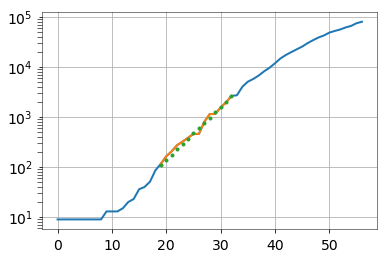

In [369]:
plt.plot(ydata)
plt.plot(t,ydata[t])
(rd0,lam),pconv=scipy.optimize.curve_fit(lambda x,a,b: a*np.exp(b*x),  t,  ydata[t],  p0=(0.5, 0.3))
plt.plot(t,rd0*np.exp(lam*t),'.')
plt.yscale("log")
plt.grid()
print(t0,rd0,lam)


In [370]:
def seiirr_ivp(x,y,p,beta,Td,Tr,Tl,N):
    S,E,Iu,Id,Rd,Ru = y
    sigma = 1/Tl
    Sd = -beta * (Id + Iu) * S/N
    Ed = beta * (Id + Iu) * S/N - sigma * E
    Iud = (1-p) * sigma * E - Iu/Tr
    Idd = p * sigma * E - Id/Td
    Rdd = Id/Td
    Rud = Iu/Tr
    return Sd, Ed, Iud, Idd, Rdd, Rud

In [371]:
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0]
l=None
N = population
Tl = 5
Tr = 15
Td = 7

sigma= 1./Tl
gammaD = 1./Td
gammaR= 1./Tr

p=0.001
Rd0=rd0*np.exp(lam*t0)

beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))
coeff=[1,(gammaD + gammaR + sigma), gammaD*gammaR + sigma*(gammaD+gammaR-beta), p*beta*sigma*(gammaD-gammaR) + sigma*gammaD*(gammaR-beta) ]
coeff=np.array(coeff)
lambdas=np.roots(coeff)
print(lambdas)



[-0.50982271  0.2430822  -0.1427833 ]


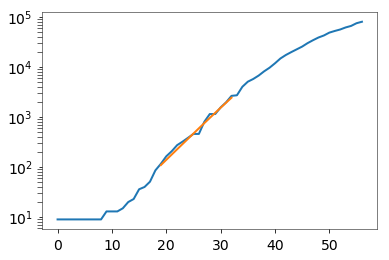

In [387]:
Rd0=rd0*np.exp(lam*t0)
beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))
max_days=t0+14#len(ydata)
#beta=0.68
Id0= lam/gammaD * Rd0
E0 = (gammaD+lam)*Id0/(p*sigma)
Iu0 = (1-p)*sigma*E0/(gammaR + lam)
Ru0 = gammaR/lam *Iu0
S0 =  N-(sigma+lam)/lam * E0
sol = integrate.solve_ivp(seiirr_ivp, [t0, max_days+1], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,beta,Td,Tr,Tl,N),t_eval=np.arange(t0,max_days),method='RK45')
plt.plot(ydata)
plt.plot(sol.t,sol.y[4,:],label = 'ODE R_d' ,linewidth=2)
#plt.plot(sol.t,sol.y[2,:],label='I_u')
#plt.plot(sol.t,sol.y[3,:],label='I_d')
plt.yscale('log')

In [373]:
l0=lambdas[lambdas>0][0]
l1,l2=lambdas[lambdas<0]

147183.81779973547 218.97658934233107 -0.5098227128526712 -0.1427832953076611


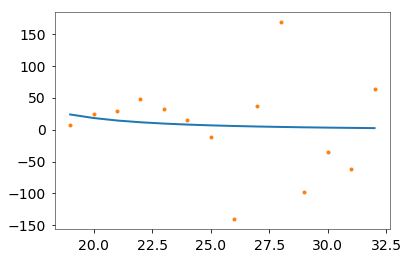

In [374]:
yrem=ydata[t]-rd0*np.exp(l0*t)
(rd1,rd2),pconv=scipy.optimize.curve_fit(lambda x,rd1,rd2: rd1*np.exp(x*l1)+rd2*np.exp(x*l2),  t,  yrem,  p0=(400, -400))
plt.plot(t,rd1*np.exp(t*l1)+rd2*np.exp(t*l2))
plt.plot(t,yrem,'.')
print(rd1,rd2,l1,l2)

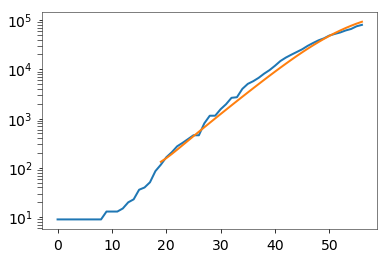

In [392]:
Rd0=rd0*np.exp(l0*t0)
Rd1=rd1*np.exp(l1*t0)
Rd2=rd2*np.exp(l2*t0)
beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))
max_days=len(ydata)
def ics(lam,Rd0):    
    Id0= lam/gammaD * Rd0
    E0 = (gammaD+lam)*Id0/(p*sigma)
    Iu0 = (1-p)*sigma*E0/(gammaR + lam)
    Ru0 = gammaR/lam *Iu0
    S0 =  -(sigma+lam)/lam * E0
    return np.array([N-S0, E0, Iu0, Id0, Rd0, Ru0])
y0 = ics(l0,Rd0) + ics(l1,Rd1)+ics(l2,Rd2) 
beta=0.18
sol = integrate.solve_ivp(seiirr_ivp, [t0, max_days+1], y0, args=(p,beta,Td,Tr,Tl,N),t_eval=np.arange(t0,max_days),method='RK45')
plt.plot(ydata)
plt.plot(sol.t,sol.y[4,:],label = 'ODE R_d' ,linewidth=2)
#plt.plot(sol.t,sol.y[2,:],label='I_u')
#plt.plot(sol.t,sol.y[3,:],label='I_d')
plt.yscale('log')

In [300]:
y0

array([-3.83938898e+05,  2.32824481e+05,  1.13617929e+05,  1.38954185e+02,
        1.33051767e+02,  3.72244824e+04])

In [376]:
beta

0.68635653885897